In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier


DATA_PATH = './data/'
DATA_SET_CSV = 'dataset.csv'

#csv파일 읽기
dataset = pd.read_csv(DATA_PATH+DATA_SET_CSV)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
#벡터화
cv = CountVectorizer(max_features=4000, ngram_range = (1,2), token_pattern = "[a-z0-9-._:]+")
codes = list(dataset['code'])
X = cv.fit_transform(codes)
y = np.array(dataset['sentiment'])


In [3]:
#csv파일 제대로 읽었는지 확인
print(np.count_nonzero(y == 0))
print(np.count_nonzero(y == 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

14516
1002


In [8]:
names = ["GBM+XGB","GBM+Ada","XGB+Ada","GBM+XGB+Ada"]
prob = []

classifiers2 = XGBClassifier(n_estimators = 150, learning_rate = 0.2, max_depth=8) 
classifiers3=AdaBoostClassifier(n_estimators=300)
classifiers4 = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.04)

eclf1 = VotingClassifier(estimators=[('gbm', classifiers4), ('xgb', classifiers2)],voting='soft',weights=[2,4])
eclf2 = VotingClassifier(estimators=[('gbm', classifiers4), ('ada', classifiers3)],voting='soft')
eclf3 = VotingClassifier(estimators=[('xgb', classifiers2), ('ada', classifiers3)],voting='soft',weights=[4,2])
eclf4 = VotingClassifier(estimators=[('gbm', classifiers4), ('xgb', classifiers2), ('ada', classifiers3)],voting='soft',weights=[2,4,2])

i = 0
for model in (eclf1, eclf2, eclf3, eclf4):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    prob.append(model.predict_proba(X_test))
    print(names[i])
    i += 1
    print("정확도: {}".format(accuracy_score(y_test, y_pred)))
    print("정밀도: {}".format(precision_score(y_test, y_pred)))
    print("재현율: {}".format(recall_score(y_test, y_pred)))
    print("F1: {}".format(f1_score(y_test, y_pred)))
    print()

GBM+XGB
정확도: 0.9890463917525774
정밀도: 0.9882352941176471
재현율: 0.84
F1: 0.9081081081081082

GBM+Ada
정확도: 0.9861469072164949
정밀도: 0.9815950920245399
재현율: 0.8
F1: 0.8815426997245179

XGB+Ada
정확도: 0.9884020618556701
정밀도: 0.9767441860465116
재현율: 0.84
F1: 0.9032258064516129

GBM+XGB+Ada
정확도: 0.9890463917525774
정밀도: 0.9882352941176471
재현율: 0.84
F1: 0.9081081081081082



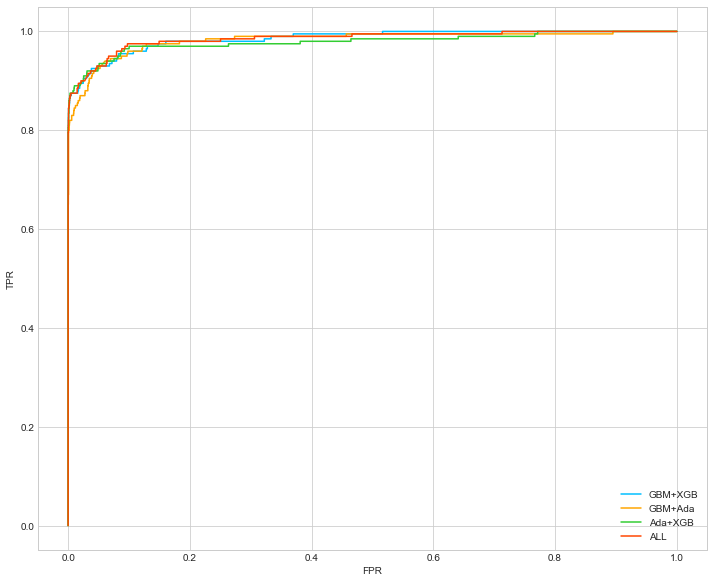

In [9]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr0, tpr0, thresholds0 = roc_curve(y_test, prob[0][:,1])
fpr1, tpr1, thresholds1 = roc_curve(y_test, prob[1][:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, prob[2][:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, prob[3][:,1])
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,10))
plt.plot(fpr0, tpr0, color = 'deepskyblue', label = 'GBM+XGB')
plt.plot(fpr1, tpr1, color = 'orange', label = 'GBM+Ada')
plt.plot(fpr2, tpr2, color = 'limegreen', label = 'Ada+XGB')
plt.plot(fpr3, tpr3, color = 'orangered', label = 'ALL')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import roc_auc_score
print("XGB+GBM:",roc_auc_score(y_test, prob[0][:,1]))
print("GBM+Ada:",roc_auc_score(y_test, prob[1][:,1]))
print("Ada+XGB:",roc_auc_score(y_test, prob[2][:,1]))
print("ALL:",roc_auc_score(y_test, prob[3][:,1]))

XGB+GBM: 0.9853366046831956
GBM+Ada: 0.9826842286501378
Ada+XGB: 0.9788851584022038
ALL: 0.9866003787878788


In [21]:
from sklearn.metrics import confusion_matrix
#최종 모델의 혼동행렬
y_pred = eclf4.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[2902,    2],
       [  32,  168]], dtype=int64)

In [11]:
import joblib
#카운트벡터, 모델 저장
finalcount = joblib.dump(cv,'./countvector.pkl')
finalmodel = joblib.dump(eclf4,'./model.pkl')